## Capstone Project: Predicting the Result of European Club Soccer Matches

### Overview:

#### Problem: 
* The main motivation behind my analysis is to use the predictions to come up with a strong betting strategy that gives a healthy return on investment

#### Dateset Acquisition: 
* [Kaggle link](https://www.kaggle.com/hugomathien/soccer/home)

#### Data Wrangling:
* [Merging Player Attributes by position](#Merging1)
* [Merging Team Attributes](#Merging2)

#### Exploratory Data Analysis:
* [Distribution of FIFA Player Attributes](#Player_Attributes)
* [Null Value Exploration and Imputation](#DroppingNulls)


#### Feature Engineering: 
* [Player Features](#Player_Features) were selected based on player position and the distribution of the feature.

* [Team Features](#Team_Features) were selected based on domain knowledge.

* Created algorithms for [team form](#team_form), [defensive form](#def_form), [attacking form](#att_form), [head-to-head record](#headtohead)
                     
#### Modeling The Data:
* [Train](#train) on match data from 2008 to 2014 in 9 European Leagues  [Test](#test) on matches from 2015-2016

* Machine Learning : [Logistic Regression](#Log), [KNN](#KNN), [SVM](#SVM), [XGBoost](#XGboost)

#### Evaluation:

* [Evaluated against accuracy scores against dummy classifiers](#Eval)

* Using the model as a betting strategy: [Strategy 1](#Bet1) , [Strategy 2](#Bet2)

#### [Conclusion](#Conclusion)

In [1]:
import sqlite3
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
import matplotlib.patches as mpatches
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.externals import joblib
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

cnx = sqlite3.connect('database.sqlite 2')

Populating the interactive namespace from numpy and matplotlib


In [2]:
Country = pd.read_sql_query("SELECT * FROM Country", cnx)
League = pd.read_sql_query("SELECT * FROM League", cnx)
Match = pd.read_sql_query("SELECT * FROM Match", cnx)
Player = pd.read_sql_query("SELECT * FROM Player", cnx)
Player_Attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
Team = pd.read_sql_query("SELECT * FROM Team", cnx)
Team_Attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", cnx)

##### Creating Results Label:

* 1 for a home team winning
* 0 for a draw
* -1 for the home team losing

In [3]:
# Creating the Results training label

Match['Result'] = Match['home_team_goal'] - Match['away_team_goal'] #Draw
Match['Result'].loc[Match.Result > 0 ] = 1 #Home Win
Match['Result'].loc[Match.Result < 0] = -1 # Home Loss

##### Date Preprocessing

In [4]:
#Preprocessing Date Columns

Match['stage'] = pd.to_datetime(Match['date']).dt.year
Match = Match.rename(columns={'stage': 'date_year'})
Match['date'] = pd.to_datetime(Match['date'])

Player_Attributes['date']= pd.to_datetime(Player_Attributes['date']).dt.year 
Team_Attributes['date']= pd.to_datetime(Team_Attributes['date']).dt.year 

#Sort Match table by date:
Match = Match.sort_values(by='date',ascending = True)

<a id='team_form'></a>
##### Team Form Feature Creation:

In [5]:
#Home Team Form Algorithim
def Form_Home_Team (df):
    
    ''' Returns the sum of the 'Result' column for the last ten matches for the home team'''
    
    team = df['home_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team) | (Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    score = last_matches['Result'].sum()
    return score

#Away Team Form Algorithim
def Form_Away_Team (df):
    
    ''' Returns the sum of the 'Result' column for the last ten matches for the home team'''
    
    team = df['away_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team) | (Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    score = last_matches['Result'].sum()
    return score
    

In [6]:
Match['Home_Team_Form'] = Match.apply(lambda x: Form_Home_Team(x),axis=1 )
Match['Away_Team_Form'] = Match.apply(lambda x: Form_Away_Team(x),axis=1 )

<a id='att_form'></a>
##### Attacking Form Feature Creation:

In [7]:
#function to get goals scored by a team
def goals_scored_calc(df, team):
    
    '''Returns goals scored by both teams in previous 10 matches'''
    
    home_goals = int(df['home_team_goal'][df['home_team_api_id'] == team].sum())
    away_goals = int(df['away_team_goal'][df['away_team_api_id'] == team].sum())
    total_goals = home_goals + away_goals
    return total_goals

In [8]:
#Home Team Attacking Form Algorithim
def Home_Team_Goal_Scoring_Form (df):
    
    ''' Returns the goals scored by the home team in prevous 10 matches'''
    
    team = df['home_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team) | (Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    return goals_scored_calc(last_matches,team)
    
#Away Team Attacking Form Algorithim
def Away_Team_Goal_Scoring_Form (df):
    
    ''' Returns the goals scored by the away team in prevous 10 matches'''
    
    team = df['away_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team) | (Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    return goals_scored_calc(last_matches,team)
    

In [9]:
Match['Home_Team_Goal_Scoring_Form'] = Match.apply(lambda x: Home_Team_Goal_Scoring_Form(x),axis=1 )
Match['Away_Team_Goal_Scoring_Form'] = Match.apply(lambda x: Away_Team_Goal_Scoring_Form(x),axis=1 )

<a id='def_form'></a>
##### Defensive Form Feature Creation:

In [10]:
#function to get goals conceded by a team
def goals_conceded_calc(df, team):
    
    '''Returns goals conceded by both teams in previous 10 matches'''
    
    home_goals_conceded = int(df['away_team_goal'][df['home_team_api_id'] == team].sum())
    away_goals_conceded = int(df['home_team_goal'][df['away_team_api_id'] == team].sum())
    total_goals_conceded = home_goals_conceded + away_goals_conceded
    return total_goals_conceded

In [11]:
#Home Team Defensive Form Algorithim
def Home_Team_Defensive_Form (df):
    
    ''' Returns the goals conceded by the home team in prevous 10 matches'''
    
    team = df['home_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team) | (Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    return goals_conceded_calc(last_matches,team)
    
#Away Team Defensive Form Algorithim
def Away_Team_Defensive_Form (df):
    
    ''' Returns the goals conceded by the away team in prevous 10 matches'''
    
    team = df['away_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team) | (Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    return goals_conceded_calc(last_matches,team)
    

In [12]:
Match['Home_Team_Defensive_Form'] = Match.apply(lambda x: Home_Team_Defensive_Form(x),axis=1 )
Match['Away_Team_Defensive_Form'] = Match.apply(lambda x: Away_Team_Defensive_Form(x),axis=1 )

<a id='headtohead'></a>
##### Head to Head Feature Creation:

In [13]:
#Home Team Form Algorithim
def Head_to_Head (df):
    
    ''' Returns the sum of the 'Result' column for the previous four mathes played between the two teams'''
    
    team1 = df['home_team_api_id']
    team2 = df['away_team_api_id']
    date = df['date']
    team_matches = Match[((Match['home_team_api_id'] == team1) & (Match['away_team_api_id'] == team2))|\
     ((Match['home_team_api_id'] == team2) & (Match['away_team_api_id'] == team1))]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:4,:]
    score = last_matches['Result'].sum()
    return score
    

In [14]:
#Adding head to head features
Match['Head_to_Head'] = Match.apply(lambda x: Head_to_Head(x),axis=1 )

<a id='DroppingNulls'></a>
### Cleaning

1. Dropping all bookies odds columns except Bet 365
2. Dropping home_player_X and home_player_Y columns
3. Dropping columns with no data
4. Dropping rows with null values for played ID's. (Player ID identifier is crucial in getting player rating features)
5. Dropping duplicate player attributes for the same year:

In [15]:
#1
betting_odds_indices = np.arange(Match.columns.get_loc('B365H')+3,Match.columns.get_loc('BSA')+1,1)
Match = Match.drop(Match.columns[betting_odds_indices], axis=1)

#2
X_Y_player_indices = np.arange(Match.columns.get_loc("home_player_X1"),Match.columns.get_loc("away_player_Y11")+1,1)
Match = Match.drop(Match.columns[X_Y_player_indices], axis=1) 

#3
Match = Match.drop(['goal','shoton','shotoff','foulcommit','card','cross','corner','possession',\
                   'match_api_id','season','id'], axis=1)

#4
Match = Match.dropna(subset= ['home_player_1','home_player_2','home_player_3','home_player_4','home_player_5',\
                           'home_player_6','home_player_7','home_player_8','home_player_9','home_player_10',\
                           'home_player_11','away_player_1','away_player_2','away_player_3','away_player_4',
                           'away_player_5','away_player_6','away_player_7','away_player_8','away_player_9',
                           'away_player_10','away_player_11'])

#5
Player_Attributes = Player_Attributes.drop_duplicates(subset=['player_api_id','date'])

##### Visualizing Target Variable: Match Result

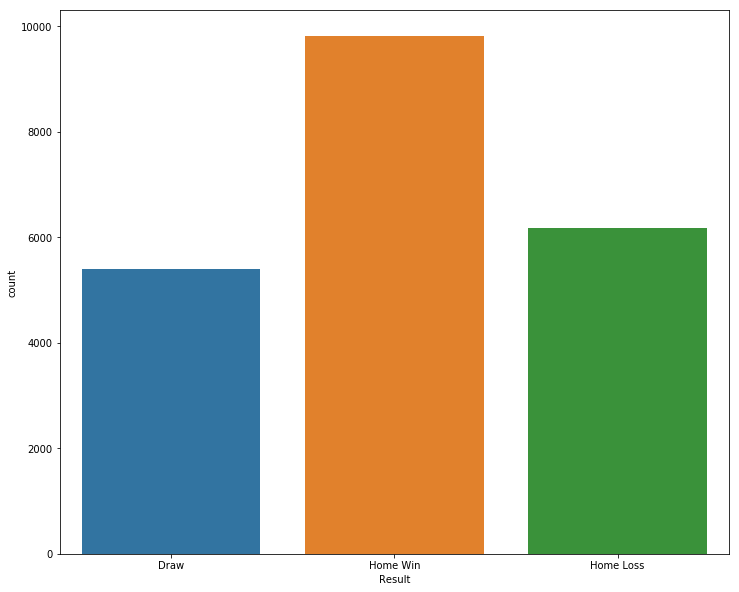

In [16]:
Match['Result'] = Match['Result'].replace([1,-1,0],['Home Win','Home Loss','Draw'])
sns.countplot(Match['Result'])
plt.show()
Match['Result'] = Match['Result'].replace(['Home Win','Home Loss','Draw'],[1,-1,0])

<a id='Player_Attributes'></a>
### Player Attributes Exploration  & Visualization:

In [17]:
Player_Attributes.describe()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,71615.000000,73059.000000,71615.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,71615.000000,73059.000000,71615.000000,73059.000000,71615.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000,71615.000000,73059.000000,73059.000000,73059.000000,71615.000000,73059.000000,73059.000000,73059.000000,73059.000000,73059.000000
mean,92100.370317,161336.039201,126788.151261,2011.340095,67.446584,72.692646,53.498597,48.237685,56.383676,60.791388,47.904741,56.990638,51.055072,47.552759,55.771308,61.556824,66.499008,66.925115,64.831963,64.981891,64.590337,59.841580,66.462291,65.908923,66.875963,51.380720,60.114469,51.990501,54.391040,57.200991,54.021407,46.490891,49.674783,47.513175,15.124434,17.611287,24.783586,17.683557,18.021298
std,53106.925473,56449.744436,133346.086777,2.907770,7.333027,6.778585,17.432631,19.202915,16.856317,14.633454,18.439440,18.045576,18.285628,17.825487,14.483485,15.540605,12.857347,12.548036,12.716214,9.379084,12.849754,16.499483,10.910055,13.162434,12.101084,18.491479,16.082722,19.043011,18.597577,14.929767,15.750907,21.272933,21.446403,21.687854,17.517688,16.341745,23.368241,16.539693,17.636146
min,1.000000,2.000000,2625.000000,2007.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,3.000000,6.000000,13.000000,12.000000,11.000000,20.000000,12.000000,2.000000,14.000000,10.000000,18.000000,1.000000,8.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,46123.500000,148758.000000,33775.000000,2009.000000,63.000000,68.000000,43.000000,32.000000,48.000000,55.000000,33.000000,48.000000,39.000000,35.000000,47.000000,56.000000,60.000000,61.000000,58.000000,59.000000,58.000000,52.000000,60.000000,60.000000,60.000000,38.000000,50.000000,35.000000,43.000000,48.000000,44.000000,25.000000,28.000000,25.000000,7.000000,9.000000,9.000000,9.000000,9.000000
50%,91845.000000,179873.000000,68861.000000,2011.000000,67.000000,73.000000,57.000000,51.000000,59.000000,64.000000,50.000000,62.000000,53.000000,48.000000,58.000000,65.000000,68.000000,68.000000,66.000000,66.000000,66.000000,63.000000,67.000000,68.000000,68.000000,55.000000,63.000000,56.000000,58.000000,59.000000,56.000000,50.000000,55.000000,53.000000,10.000000,12.000000,12.000000,12.000000,12.000000
75%,138302.500000,198076.000000,181197.000000,2014.000000,72.000000,77.000000,66.000000,64.000000,68.000000,71.000000,63.000000,70.000000,65.000000,61.000000,66.000000,72.000000,75.000000,75.000000,74.000000,71.000000,73.000000,72.000000,74.000000,75.000000,75.000000,66.000000,72.000000,67.000000,68.000000,68.000000,66.000000,65.000000,68.000000,66.000000,13.000000,21.000000,47.000000,21.000000,21.000000
max,183977.000000,234141.000000,750584.000000,2016.000000,94.000000,97.000000,95.000000,97.000000,95.000000,97.000000,93.000000,97.000000,94.000000,97.000000,97.000000,97.000000,97.000000,97.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,97.000000,96.000000,96.000000,97.000000,96.000000,94.000000,95.000000,95.000000,94.000000,92.000000,97.000000,96.000000,96.000000


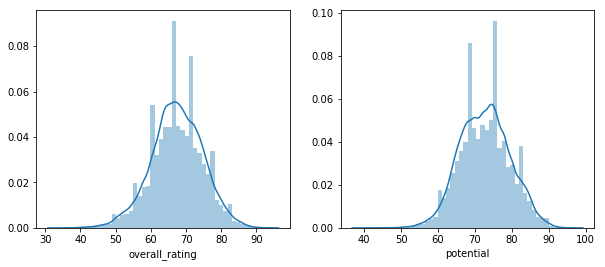

In [18]:
fig, ((ax1,ax2))=plt.subplots(ncols=2,nrows=1,figsize=(10,4))

sns.distplot(Player_Attributes['overall_rating'],ax=ax1);
sns.distplot(Player_Attributes['potential'],ax=ax2);

Goal Keeper Attributes:

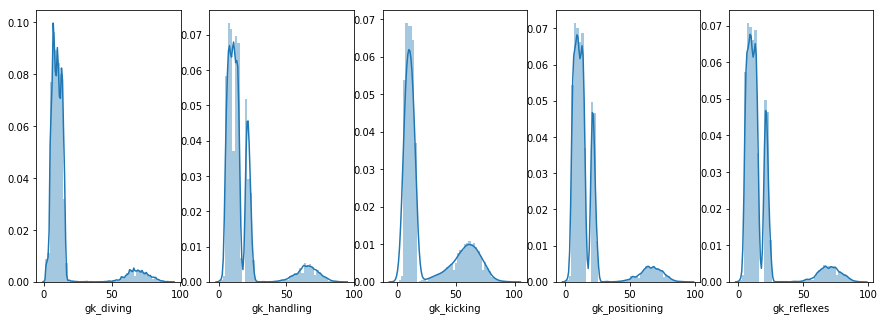

In [19]:
fig, ((ax1,ax2,ax3,ax4,ax5))=plt.subplots(ncols=5,nrows=1,figsize=(15,5))

sns.distplot(Player_Attributes['gk_diving'],ax=ax1);
sns.distplot(Player_Attributes['gk_handling'],ax=ax2);
sns.distplot(Player_Attributes['gk_kicking'],ax=ax3);
sns.distplot(Player_Attributes['gk_positioning'],ax=ax4);
sns.distplot(Player_Attributes['gk_reflexes'],ax=ax5);

Defensive Attributes:

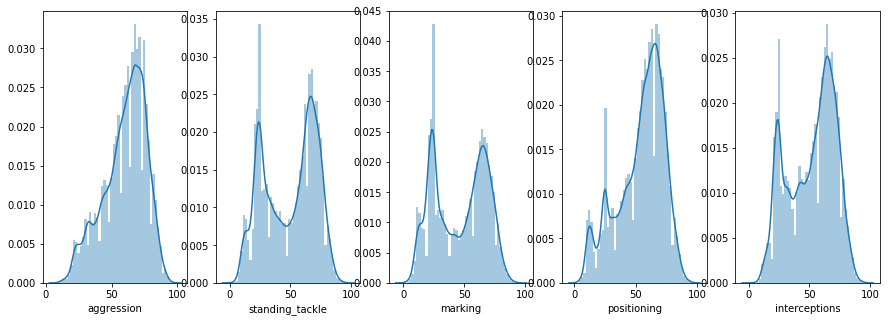

In [20]:
fig, ((ax1,ax2,ax3,ax4,ax5))=plt.subplots(ncols=5,nrows=1,figsize=(15,5))

sns.distplot(Player_Attributes['aggression'],ax=ax1);
sns.distplot(Player_Attributes['standing_tackle'],ax=ax2);
sns.distplot(Player_Attributes['marking'],ax=ax3);
sns.distplot(Player_Attributes['positioning'],ax=ax4);
sns.distplot(Player_Attributes['interceptions'],ax=ax5);

Midfielder Attributes:

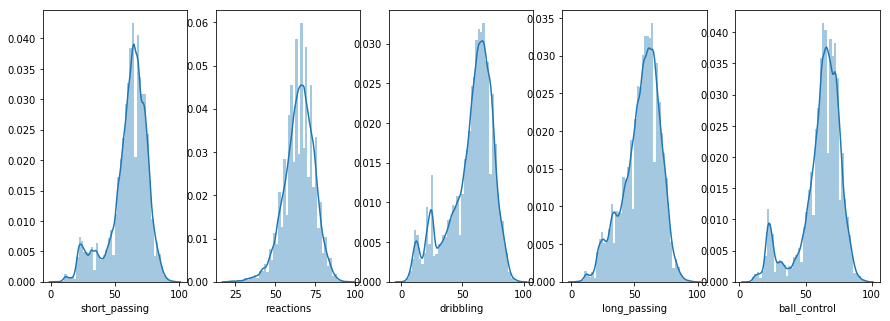

In [21]:
fig, ((ax1,ax2,ax3,ax4,ax5))=plt.subplots(ncols=5,nrows=1,figsize=(15,5))

sns.distplot(Player_Attributes['short_passing'],ax=ax1);
sns.distplot(Player_Attributes['reactions'],ax=ax2);
sns.distplot(Player_Attributes['dribbling'],ax=ax3);
sns.distplot(Player_Attributes['long_passing'],ax=ax4);
sns.distplot(Player_Attributes['ball_control'],ax=ax5);

Striker Attributes:

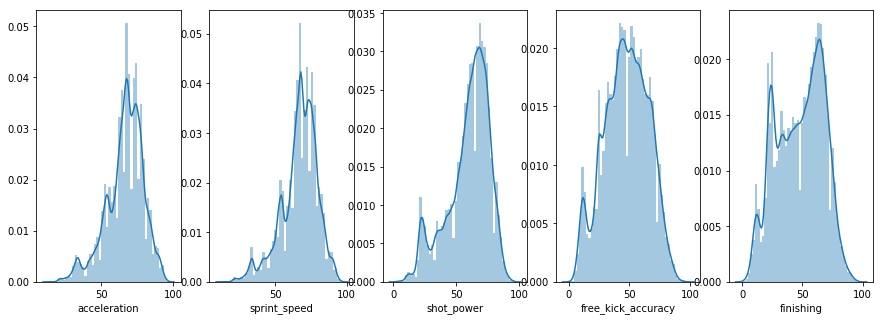

In [22]:
fig, ((ax1,ax2,ax3,ax4,ax5))=plt.subplots(ncols=5,nrows=1,figsize=(15,5))

sns.distplot(Player_Attributes['acceleration'],ax=ax1);
sns.distplot(Player_Attributes['sprint_speed'],ax=ax2);
sns.distplot(Player_Attributes['shot_power'],ax=ax3);
sns.distplot(Player_Attributes['free_kick_accuracy'],ax=ax4);
sns.distplot(Player_Attributes['finishing'],ax=ax5);

<a id='Player_Features'></a>
#### Breaking out Player Attributes  by position:

* Goalkeeper
* Defender
* Midfielder
* Striker

In [23]:
Player_Attributes_gk = Player_Attributes[['player_api_id','date','overall_rating','gk_diving']]

Player_Attributes_def = Player_Attributes[['player_api_id','date','overall_rating','positioning',\
                                           'interceptions']]

Player_Attributes_mid = Player_Attributes[['player_api_id', 'date', 'overall_rating', 'short_passing']]

Player_Attributes_str = Player_Attributes[['player_api_id', 'date', 'overall_rating', 'finishing','sprint_speed']]

Bucketing Player Attributes by years:

1. 2008-2011 
2. 2012-2014
3. 2015-2016

In [24]:
#Creating df's by year for goalkeepers
Player_Attributes_2008_2011_gk = Player_Attributes_gk[(Player_Attributes_gk['date']==2008) |
                                                      (Player_Attributes_gk['date']==2009) | 
                                                      (Player_Attributes_gk['date']==2010) | 
                                                      (Player_Attributes_gk['date']==2011)|
                                                     (Player_Attributes_gk['date']==2012)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])


Player_Attributes_2012_2014_gk = Player_Attributes_gk[(Player_Attributes_gk['date']==2012) |
                                                      (Player_Attributes_gk['date']==2013) | 
                                                      (Player_Attributes_gk['date']==2014) |
                                                      (Player_Attributes_gk['date']==2015) ].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])

    
Player_Attributes_2015_2016_gk = Player_Attributes_gk[(Player_Attributes_gk['date']==2014) |
                                                      (Player_Attributes_gk['date']==2015) |
                                                     (Player_Attributes_gk['date']==2016)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])


#Creating df's by year for defenders
Player_Attributes_2008_2011_def = Player_Attributes_def[(Player_Attributes_def['date']==2008) |
                                                      (Player_Attributes_def['date']==2009) | 
                                                      (Player_Attributes_def['date']==2010) | 
                                                      (Player_Attributes_def['date']==2011)|
                                                       (Player_Attributes_def['date']==2012)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])


Player_Attributes_2012_2014_def = Player_Attributes_def[(Player_Attributes_def['date']==2012) |
                                                      (Player_Attributes_def['date']==2013) | 
                                                      (Player_Attributes_def['date']==2014)|
                                                      (Player_Attributes_def['date']==2015)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])

                                                      
Player_Attributes_2015_2016_def = Player_Attributes_def[(Player_Attributes_def['date']==2014) |
                                                        (Player_Attributes_def['date']==2015) |
                                                        (Player_Attributes_def['date']==2016) ].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])


#Creating df's by year for mid
Player_Attributes_2008_2011_mid = Player_Attributes_mid[(Player_Attributes_mid['date']==2008) |
                                                      (Player_Attributes_mid['date']==2009) | 
                                                      (Player_Attributes_mid['date']==2010) | 
                                                      (Player_Attributes_mid['date']==2011)|
                                                       (Player_Attributes_mid['date']==2012)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])

Player_Attributes_2012_2014_mid = Player_Attributes_mid[(Player_Attributes_mid['date']==2012) |
                                                      (Player_Attributes_mid['date']==2013) | 
                                                      (Player_Attributes_mid['date']==2014) |
                                                       (Player_Attributes_mid['date']==2015)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])
                                                      
Player_Attributes_2015_2016_mid = Player_Attributes_mid[(Player_Attributes_mid['date']==2014) |
                                                      (Player_Attributes_mid['date']==2015) |
                                                       (Player_Attributes_mid['date']==2016)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])

#Creating df's by year for str
Player_Attributes_2008_2011_str = Player_Attributes_str[(Player_Attributes_str['date']==2008) |
                                                      (Player_Attributes_str['date']==2009) | 
                                                      (Player_Attributes_str['date']==2010) | 
                                                      (Player_Attributes_str['date']==2011)|
                                                        (Player_Attributes_str['date']==2012)].sort_values(by = 'date', ascending = False)\
                                                    .drop_duplicates(subset=['player_api_id'])

Player_Attributes_2012_2014_str = Player_Attributes_str[(Player_Attributes_str['date']==2012) |
                                                      (Player_Attributes_str['date']==2013) | 
                                                      (Player_Attributes_str['date']==2014) |
                                                       (Player_Attributes_str['date']==2014)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id']) 
                                                      
Player_Attributes_2015_2016_str = Player_Attributes_str[(Player_Attributes_str['date']==2014) |
                                                      (Player_Attributes_str['date']==2015)| 
                                                       (Player_Attributes_str['date']==2016)].sort_values(by = 'date', ascending = False)\
                                                        .drop_duplicates(subset=['player_api_id'])



Bucketing Matches to merge onto Player Attributes:

In [25]:
Match_2008_2011 = Match[(Match['date_year']==2008)|(Match['date_year']==2009)| (Match['date_year']==2010)|
                       (Match['date_year']==2011)]

Match_2012_2014 = Match[(Match['date_year']==2012)| (Match['date_year']==2013)| (Match['date_year']==2014)]

Match_2015_2016  = Match[(Match['date_year']==2015)| (Match['date_year']==2016)]


<a id='Merging1'></a>
Merging Player Attributes by position onto Match dataframes:

In [26]:
#2008 - #2011 

#Home Player merges
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_gk, how = 'left',left_on='home_player_1',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_def, how = 'left',left_on='home_player_2',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_def, how = 'left',left_on='home_player_3',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_def, how = 'left',left_on='home_player_4',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_def, how = 'left',left_on='home_player_5',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_mid, how = 'left',left_on='home_player_6',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_mid, how = 'left',left_on='home_player_7',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_mid, how = 'left',left_on='home_player_8',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_mid, how = 'left',left_on='home_player_9',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_str, how = 'left',left_on='home_player_10',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_str, how = 'left',left_on='home_player_11',right_on = 'player_api_id')


#Away Player merges
Match_2008_2011 = Match_2008_2011.merge(Player_Attributes_2008_2011_gk, how = 'left',left_on='away_player_1',right_on = 'player_api_id')
Match_2008_2011 = Match_2008_2011.merge(Player_Attributes_2008_2011_def, how = 'left',left_on='away_player_2',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_def, how = 'left',left_on='away_player_3',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_def, how = 'left',left_on='away_player_4',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_def, how = 'left',left_on='away_player_5',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_mid, how = 'left',left_on='away_player_6',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_mid, how = 'left',left_on='away_player_7',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_mid, how = 'left',left_on='away_player_8',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_mid, how = 'left',left_on='away_player_9',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_str, how = 'left',left_on='away_player_10',right_on = 'player_api_id')
Match_2008_2011  = Match_2008_2011.merge(Player_Attributes_2008_2011_str, how = 'left',left_on='away_player_11',right_on = 'player_api_id')

In [27]:
#2012 - #2014 

#Home Player merges 
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_gk, how = 'left',left_on='home_player_1',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_def, how = 'left',left_on='home_player_2',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_def, how = 'left',left_on='home_player_3',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_def, how = 'left',left_on='home_player_4',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_def, how = 'left',left_on='home_player_5',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_mid, how = 'left',left_on='home_player_6',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_mid, how = 'left',left_on='home_player_7',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_mid, how = 'left',left_on='home_player_8',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_mid, how = 'left',left_on='home_player_9',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_str, how = 'left',left_on='home_player_10',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_str, how = 'left',left_on='home_player_11',right_on = 'player_api_id')


#Away Player merges
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_gk, how = 'left',left_on='away_player_1',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_def, how = 'left',left_on='away_player_2',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_def, how = 'left',left_on='away_player_3',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_def, how = 'left',left_on='away_player_4',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_def, how = 'left',left_on='away_player_5',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_mid, how = 'left',left_on='away_player_6',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_mid, how = 'left',left_on='away_player_7',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_mid, how = 'left',left_on='away_player_8',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_mid, how = 'left',left_on='away_player_9',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_str, how = 'left',left_on='away_player_10',right_on = 'player_api_id')
Match_2012_2014  = Match_2012_2014.merge(Player_Attributes_2012_2014_str, how = 'left',left_on='away_player_11',right_on = 'player_api_id')


In [28]:
#2015 - #2016

#Home Player merges
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_gk, how = 'left',left_on='home_player_1',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_def, how = 'left',left_on='home_player_2',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_def, how = 'left',left_on='home_player_3',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_def, how = 'left',left_on='home_player_4',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_def, how = 'left',left_on='home_player_5',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_mid, how = 'left',left_on='home_player_6',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_mid, how = 'left',left_on='home_player_7',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_mid, how = 'left',left_on='home_player_8',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_mid, how = 'left',left_on='home_player_9',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_str, how = 'left',left_on='home_player_10',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_str, how = 'left',left_on='home_player_11',right_on = 'player_api_id')


#Away Player merges
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_gk, how = 'left',left_on='away_player_1',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_def, how = 'left',left_on='away_player_2',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_def, how = 'left',left_on='away_player_3',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_def, how = 'left',left_on='away_player_4',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_def, how = 'left',left_on='away_player_5',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_mid, how = 'left',left_on='away_player_6',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_mid, how = 'left',left_on='away_player_7',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_mid, how = 'left',left_on='away_player_8',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_mid, how = 'left',left_on='away_player_9',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_str, how = 'left',left_on='away_player_10',right_on = 'player_api_id')
Match_2015_2016  = Match_2015_2016.merge(Player_Attributes_2015_2016_str, how = 'left',left_on='away_player_11',right_on = 'player_api_id')


<a id='Team_Features'></a>

#### Team Attributes Cleaning, Pre-processing and Selection

In [29]:
Team_Attributes.describe()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,489.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,2012.506859,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,39179.857739,13264.869900,1.709201,11.545869,9.678290,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1.000000,1601.000000,2010.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,110.000000,8457.750000,2011.000000,45.000000,42.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,485.000000,8674.000000,2013.000000,52.000000,49.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,1900.000000,9904.000000,2014.000000,62.000000,55.000000,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,112513.000000,274581.000000,2015.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


In [30]:
#Drop columns:
Team_Attributes = Team_Attributes.drop(columns= (['id','team_fifa_api_id','buildUpPlaySpeedClass','buildUpPlayDribbling',\
                                                 'buildUpPlayPassingClass',\
                                                  'buildUpPlayPositioningClass','chanceCreationPassingClass',\
                                                  'chanceCreationCrossingClass','chanceCreationShootingClass',\
                                                  'chanceCreationPositioningClass','defencePressureClass',\
                                                  'defenceAggressionClass','defenceTeamWidthClass']))

In [31]:
#One hot encode categorical columns:

Team_Attributes = pd.get_dummies(Team_Attributes)

In [32]:
Team_Attributes = Team_Attributes.sort_values(by = 'date', ascending = False).drop_duplicates(subset=['team_api_id'])

<a id='Merging2'></a>
#### Merging Team Attributes by position onto Match dataframes:

In [33]:
#Merging team attributes for home and away team onto Match Dataframe

Match_2008_2011 = Match_2008_2011.merge(Team_Attributes, how = 'left',left_on='home_team_api_id',right_on = 'team_api_id')
Match_2008_2011 = Match_2008_2011.merge(Team_Attributes, how = 'left',left_on='away_team_api_id',right_on = 'team_api_id')
 
Match_2012_2014 = Match_2012_2014.merge(Team_Attributes, how = 'left',left_on='home_team_api_id',right_on = 'team_api_id')
Match_2012_2014 = Match_2012_2014.merge(Team_Attributes, how = 'left',left_on='away_team_api_id',right_on = 'team_api_id')

Match_2015_2016 = Match_2015_2016.merge(Team_Attributes, how = 'left',left_on='home_team_api_id',right_on = 'team_api_id')
Match_2015_2016 = Match_2015_2016.merge(Team_Attributes, how = 'left',left_on='away_team_api_id',right_on = 'team_api_id')

## Modelling

<a id='train'></a>
<a id='test'></a>

##### Splitting Training and Test Data for Modelling:

* Training data: Matches played between 2008 and 2014

* Test data: Matches played between 2015 and 2016

In [34]:
Train_range = [Match_2008_2011,Match_2012_2014]
Test_range =  [Match_2015_2016]

Match_Train = pd.concat(Train_range)
print(f'Training dataframe shape before dropping null values: {Match_Train.shape}')

Match_Test = pd.concat(Test_range)
print(f'Test dataframe shape before dropping null values: {Match_Test.shape}')

Match_Train = Match_Train.dropna()
Match_Test = Match_Test.dropna()

print(f'Training dataframe shape after dropping null values: {Match_Train.shape}')
print(f'Test dataframe shape after dropping null values: {Match_Test.shape}')

Training dataframe shape before dropping null values: (16848, 171)
Test dataframe shape before dropping null values: (4526, 171)
Training dataframe shape after dropping null values: (15457, 171)
Test dataframe shape after dropping null values: (3978, 171)


In [35]:
#Dropping unncessary columns to select features to be fed into model:

#Features and labels are after Result column
Train = (Match_Train.iloc[:,Match_Train.columns.get_loc('Result'):]).drop(['player_api_id_x','date_y',\
                                                                             'player_api_id_y','date_x',\
                                                                            'team_api_id_x','team_api_id_y',\
                                                                             'date'],1)


Test = (Match_Test.iloc[:,Match_Test.columns.get_loc('Result'):]).drop(['player_api_id_x','date_y',\
                                                                             'player_api_id_y','date_x',\
                                                                            'team_api_id_x','team_api_id_y',\
                                                                             'date'],1)

print(f'Training dataframe shape after dropping unncessary columns: {Train.shape}')
print(f'Testing dataframe shape after dropping unncessary columns: {Test.shape}')

Training dataframe shape after dropping unncessary columns: (15457, 90)
Testing dataframe shape after dropping unncessary columns: (3978, 90)


In [36]:
x_train = Train.iloc[:,1:]
y_train = Train.iloc[:,0]
x_test = Test.iloc[:,1:]
y_test = Test.iloc[:,0]

<a id='Log'></a>
### Logisitic Regression:

##### Note: This grid search to optimize hyper parameters took 6 hours to run previously thus commented out

In [37]:
# # Create a preprocessing object that includes StandardScaler features and PCA

# preprocess = FeatureUnion([("std", StandardScaler()), ("pca", PCA()),("F_value",SelectKBest(f_classif) )])

# # Create a pipeline
    
# pipe = Pipeline([("preprocess", preprocess),
#                 ("classifier", LogisticRegression())])

# # Create space of candidate values
# search_space = [{"preprocess__pca__n_components": [85,80],
#                  "preprocess__F_value__k": [80,85],
#                  "classifier__penalty": [ "l1","l2"],
#                  "classifier__C": np.logspace(-3, 2, 10)}]

# # Create grid search
# log_test_1 = GridSearchCV(pipe, search_space, cv=5, verbose=1, n_jobs=-1)

# #Fit the grid search
# log_test_1.fit(x_train,y_train)

In [38]:
log_test_1 = joblib.load('logistic_grid_search.pkl')

In [39]:
print(f'Logistic Regression grid search best parameters: {log_test_1.best_params_}')

print(f'Logistic Regression grid search best cross validation score: {log_test_1.best_score_}')

Logistic Regression grid search best parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l1', 'preprocess__F_value__k': 85, 'preprocess__pca__n_components': 85}
Logistic Regression grid search best cross validation score: 0.5405964934980915


Fitting Logistic Regression without dimension / feature reduction as extensize feature reduction was conducted during pre-processing so no PCA or ANOVA testing done to reduce features.

In [40]:
# estimators = [('normalise',StandardScaler()),
#               ('logit', LogisticRegression(C= 0.001,solver='lbfgs'))]

# pipe_2 = Pipeline(estimators)

# pipe_2.fit(x_train, y_train)

In [41]:
pipe_2 = joblib.load('logistic_final.pkl')

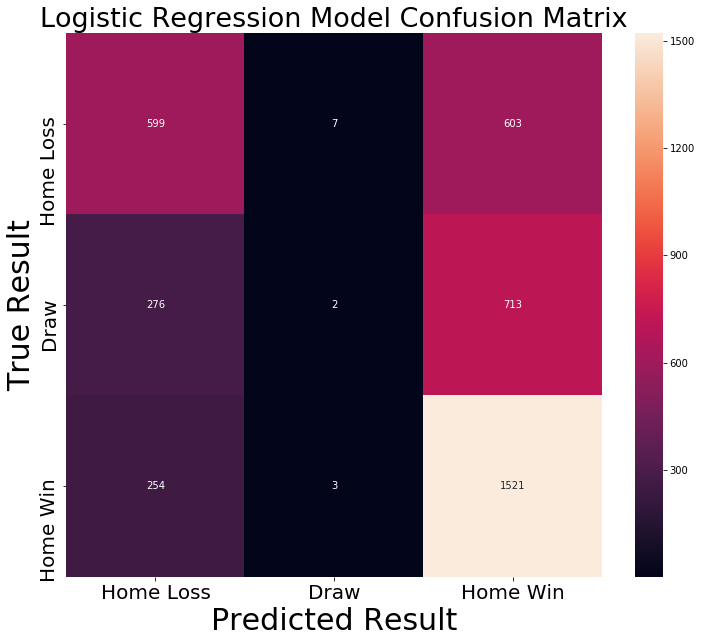

<Figure size 1152x648 with 0 Axes>

In [42]:
ax = plt.subplot();
confusion_log = confusion_matrix(y_test, pipe_2.predict(x_test))
plt.figure(figsize=(16,9));
sns.heatmap(confusion_log,annot =True,fmt='g',ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted Result',fontsize=30);ax.set_ylabel('True Result',fontsize=30); 
ax.set_title('Logistic Regression Model Confusion Matrix',fontsize=27); 
ax.xaxis.set_ticklabels(['Home Loss','Draw','Home Win'],fontsize=20); ax.yaxis.set_ticklabels(['Home Loss','Draw','Home Win'],fontsize=20);
plt.show();

<a id='KNN'></a>

### K-Nearest Neighbours


##### Note: This grid search to optimize hyper parameters ran over night previously (not being re-run)

In [43]:
# # Create a preprocessing object that includes StandardScaler features and PCA

# preprocess = FeatureUnion([("std", StandardScaler()), ("pca", PCA())])

# # Create a pipeline
    
# pipe = Pipeline([("preprocess", preprocess),
#                 ("classifier", KNeighborsClassifier())])

# # Create space of candidate values
# search_space = [{"preprocess__pca__n_components": [85,80],
#                  "classifier__n_neighbors": list(range(15,18,21,24))}]

# # Create grid search
# knn_grid = GridSearchCV(pipe, search_space, cv=2, verbose=1, n_jobs=-1)

# knn_grid.fit(x_train,y_train)

# print(f'Best KNN Cross Validation score: {knn_grid.best_score_}')

In [44]:
# estimators = [('normalise',StandardScaler()),
#               ('KNN', KNeighborsClassifier(n_neighbors=22))]

# pipe_3_KNN = Pipeline(estimators)

# pipe_3_KNN.fit(x_train, y_train)

In [45]:
pipe_3_KNN = joblib.load('KNN_final.pkl')

In [46]:
print(f'Best KNN score: {pipe_3_KNN.score(x_test, y_test)}')

Best KNN score: 0.5010055304172951


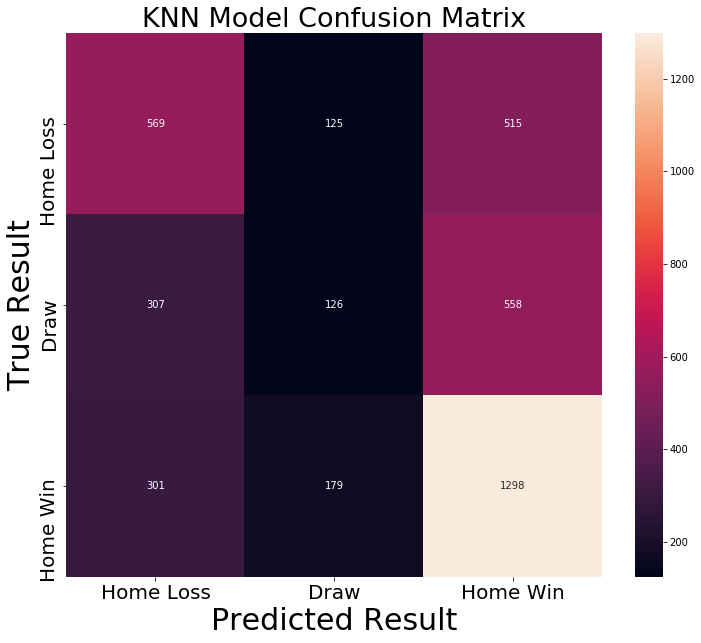

<Figure size 1152x648 with 0 Axes>

In [47]:
ax= plt.subplot();
confusion_KNN = confusion_matrix(y_test, pipe_3_KNN.predict(x_test))
plt.figure(figsize=(16,9));
sns.heatmap(confusion_KNN,annot =True,fmt='g',ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted Result',fontsize=30);ax.set_ylabel('True Result',fontsize=30); 
ax.set_title('KNN Model Confusion Matrix',fontsize=27); 
ax.xaxis.set_ticklabels(['Home Loss','Draw','Home Win'],fontsize=20); ax.yaxis.set_ticklabels(['Home Loss','Draw','Home Win'],fontsize=20);
plt.show();

<a id='XGboost'></a>


### XG-Boost

##### Note: This grid search to optimize hyper parameters ran over night previously (not being re-run)

In [48]:
#Renaming feature column names so they are unique to use in XGBoost

x_train_xgb = x_train.copy()
x_train_xgb.columns = np.arange(1,90)

x_test_xgb = x_test.copy()
x_test_xgb.columns = np.arange(1,90)

In [49]:
# param_test = {
#  'max_depth':np.arange(4,10,2),
#  'min_child_weight': np.arange(9,15,2)
# }

# xgboost_gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.15, n_estimators=900, max_depth=5,
#  min_child_weight=1, gamma=4, subsample=0.6, colsample_bytree=0.8,
#  objective= 'multi:softmax', njobs=-1, scale_pos_weight=1), 
#  param_grid = param_test, scoring='accuracy',n_jobs=-1,iid=False, cv=2)

# xgboost_gsearch.fit(x_train_xgb,y_train)

# xgboost_gsearch.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [50]:
# dec2_test2 = XGBClassifier(learning_rate=0.25, n_estimators=1000, objective='multi:softmax',reg_alpha = 50,
#                     silent=True, n_jobs=-1, colsample_bytree= 1,gamma= 0.5, max_depth=20, min_child_weight= 6, subsample=0.45)
# dec2_test2.fit(x_train_xgb,y_train)
# dec2_test2.score(x_test_xgb,y_test)

In [51]:
dec2_test2 = joblib.load('XGBoost_final.pkl')

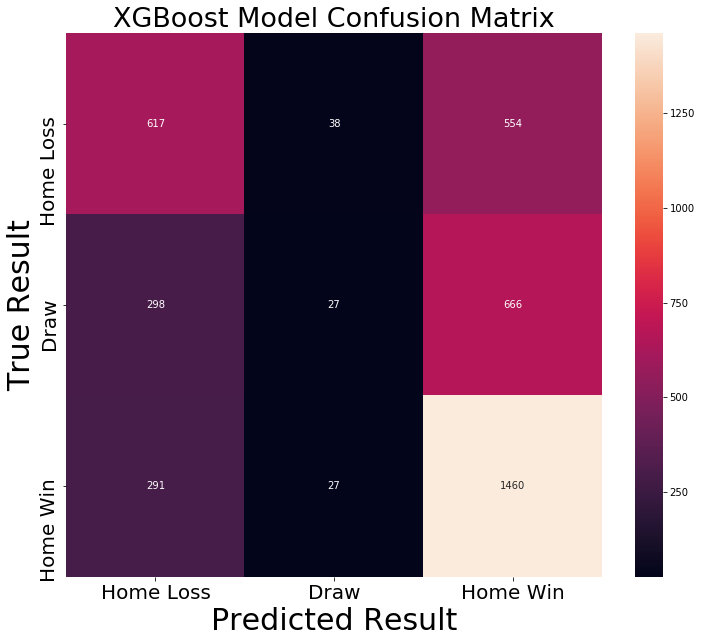

<Figure size 1152x648 with 0 Axes>

In [52]:
ax= plt.subplot();
confusion_xgboost = confusion_matrix(y_test, dec2_test2.predict(x_test_xgb))
plt.figure(figsize=(16,9));
sns.heatmap(confusion_xgboost,annot =True,fmt='g',ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted Result',fontsize=30);ax.set_ylabel('True Result',fontsize=30); 
ax.set_title('XGBoost Model Confusion Matrix',fontsize=27); 
ax.xaxis.set_ticklabels(['Home Loss','Draw','Home Win'],fontsize=20); ax.yaxis.set_ticklabels(['Home Loss','Draw','Home Win'],fontsize=20);
plt.show();

<a id='SVM'></a>

### SVM

##### Note: This grid search to optimize hyper parameters ran over night previously (not being re-run)

In [53]:
# # Create a preprocessing object that includes StandardScaler

# preprocess = FeatureUnion([("std", StandardScaler())])
    
# pipe = Pipeline([("preprocess", preprocess),
#                 ("classifier", SVC())])

# # Create space of candidate values
# search_space = [{"classifier__kernel": ["poly","rbf","sigmoid"],
#                  "classifier__gamma": np.logspace(-9, 3, 13),
#                  "classifier__C": np.logspace(-3, 3, 10)}]

# # Create grid search
# SVM_test2 = GridSearchCV(pipe, search_space, cv=2, verbose=1, n_jobs=-1)

# SVM_test2.fit(x_train,y_train)

Loading the model:

In [54]:
SVM_test2 = joblib.load('SVM_final.pkl')
print(f'(SVM best parameters after grid search: {SVM_test2.best_params_}')

(SVM best parameters after grid search: {'classifier__C': 46.41588833612773, 'classifier__gamma': 1e-05, 'classifier__kernel': 'rbf'}


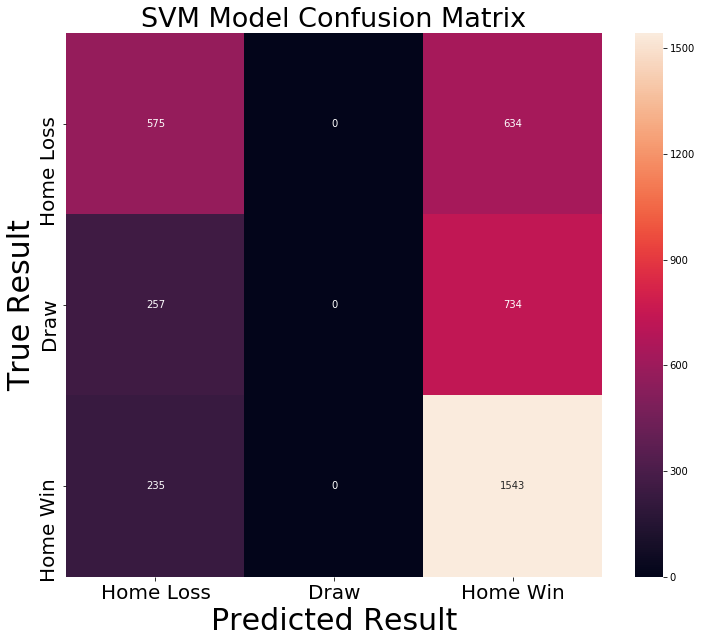

<Figure size 1152x648 with 0 Axes>

In [55]:
ax= plt.subplot();
confusion_svm = confusion_matrix(y_test, SVM_test2.predict(x_test))
plt.figure(figsize=(16,9));
sns.heatmap(confusion_svm,annot =True,fmt='g',ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted Result',fontsize=30);ax.set_ylabel('True Result',fontsize=30);  
ax.set_title('SVM Model Confusion Matrix',fontsize=27); 
ax.xaxis.set_ticklabels(['Home Loss','Draw','Home Win'],fontsize=20); ax.yaxis.set_ticklabels(['Home Loss','Draw','Home Win'],fontsize=20);
plt.show();

<a id='Eval'></a>
# Model Evaluation:

* Stratified Classifier: makes predictions that are proportional to the target vector's class proportions
* Uniform Classifier: makes predictions uniformally at random between the three classes
* Most Frequent: makes the prediction of the most frequent class every time (Home Win)

In [56]:
dummy_strat = DummyClassifier(strategy='stratified') 

# "Train" model
dummy_strat = dummy_strat.fit(x_train, y_train)
dummy_strat_score = dummy_strat.score(x_test,y_test)
print(dummy_strat_score)

0.35545500251382606


In [57]:
dummy_uniform = DummyClassifier(strategy='uniform') 

# "Train" model
dummy_uniform = dummy_uniform.fit(x_train, y_train)
dummy_uniform_score = dummy_uniform.score(x_test,y_test)
print(dummy_uniform_score)

0.33609854198089495


In [58]:
dummy_most_frequent = DummyClassifier(strategy='most_frequent') 

# "Train" model
dummy_most_frequent = dummy_most_frequent.fit(x_train, y_train)
dummy_most_frequent_score = dummy_most_frequent.score(x_test,y_test)
print(dummy_most_frequent_score)

0.4469582704876823


In [59]:
scores = {"Logistic Regression": pipe_2.score(x_test, y_test),
            "KNN": pipe_3_KNN.score(x_test, y_test),
           "XGBoost": dec2_test2.score(x_test_xgb, y_test),
           "SVM":SVM_test2.score(x_test, y_test)}

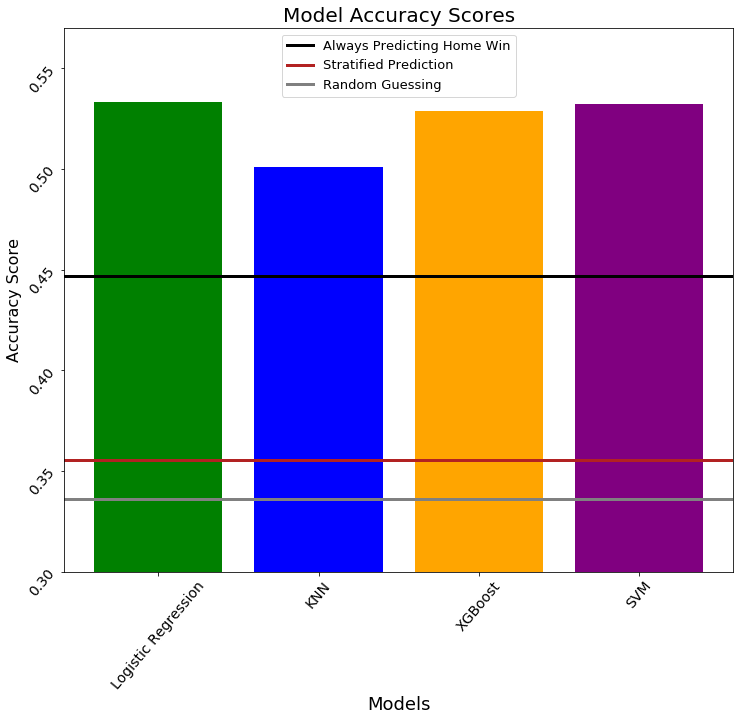

In [60]:
names = list(scores.keys())
values = list(scores.values())
plt.bar(0,values[0],tick_label=names[0],color='green')
plt.bar(1,values[1],tick_label=names[1],color='blue')
plt.bar(2,values[2],tick_label=names[2],color='orange')
plt.bar(3,values[3],tick_label=names[3],color='purple')
plt.xticks(range(0,4),names)
plt.ylim(0.30, 0.57)
plt.title("Model Accuracy Scores", fontsize=20)
plt.xlabel('Models', fontsize=18)
plt.ylabel('Accuracy Score', fontsize=16)
plt.xticks(fontsize=14, rotation=50)
plt.yticks(fontsize=14, rotation=50)

#Most frequent accuracy score horizontal line
plt.axhline(y=dummy_most_frequent_score, xmin=0, xmax=4,color='black',label='Always Predicting Home Win',linewidth=3.0)

#Stratified predictions
plt.axhline(y=dummy_strat_score, xmin=0, xmax=4,color='firebrick',label='Stratified Prediction',linewidth=3.0,)

#Random guessing horizontal line
plt.axhline(y=dummy_uniform_score, xmin=0, xmax=4,color='gray',label='Random Guessing',linewidth=3.0,)

plt.legend(loc=9, prop={'size': 13})

plt.show()

## Model Accuracy vs The Bookies Accuracy

The bookies predicted result is the result with the lowest odds (highest probability)

In [61]:
#Merge Leauge name onto Match Dataframe for per leauge analysis and visualization

Match_Test_Leagues =  Match_Test.merge(League, how = 'left', left_on='league_id', right_on='id')

#Rename 'name' column to League
Match_Test_Leagues = Match_Test_Leagues.rename(columns={'name': 'League'})

#Adding a column of ones to total matches 
Match_Test_Leagues['Total Matches'] = np.where(Match_Test_Leagues.index.notnull(),1,0)

In [62]:
# Function to get the bookies prediction and score if it was correct

# 1 for a correct prediction and 0 for an incorrect prediction

def bookies_checker (df):
    
    ''' Returns 1 for a correct predicted result and 0 for incorrect predicted result for the bookies'''
    
    Result = df['Result']    # actual result -1,0,1
    
    probabilities = []       # list to append the bookies implied probability  
    
    #append the probabilities in ORDER.. homeloss, draw, homewin. Order matters due to if condition below
    
    probabilities.append((100/df['B365A'])/100)     #appending home loss / away win probability first
    probabilities.append((100 / df['B365D'])/100)   #appending draw probability second
    probabilities.append((100 / df['B365H'])/100) #appending home win probability third
    
    # check the INDEX of the highest probability in list and impute implied predicted result accordingly. 
    
    if (probabilities.index(max(probabilities)) == 0): #if index of highest probability is 0 then prediction is home loss
        bookies_prediction = -1
    elif (probabilities.index(max(probabilities)) == 1): #if index of highest probability is 1 then prediction is home draw
        bookies_prediction = 0
    else:
        bookies_prediction = 1                    #if index of highest probability is 2 then prediction is home win
    
    #Check actual result to bookies prediction and return
    
    if bookies_prediction == Result:
        correct_prediction = 1
    else:
        correct_prediction = 0
    
    
    return correct_prediction

In [63]:
# Precited result by Logistic Model
Match_Test_Leagues['Model_Prediction'] = pipe_2.predict(x_test)

In [64]:
# Function to calculate whether the model prediction was correct

def model_checker (df):
    
    Result = df['Result']    # actual result -1,0,1
    
    Model_prediction = df['Model_Prediction']
    
    if Result == Model_prediction:
        model_correct = 1
    else:
        model_correct = 0
    
    return model_correct

In [65]:
#Create column for bookies and models score

Match_Test_Leagues['Bookies_score'] = Match_Test_Leagues.apply(lambda x: bookies_checker(x), axis =1)
Match_Test_Leagues['Model_score'] = Match_Test_Leagues.apply(lambda x: model_checker(x), axis =1)

In [66]:
Match_Test_Leagues_plot1 = Match_Test_Leagues.groupby(['League']).agg({'Bookies_score':sum, 'Model_score':sum,
                                         'Total Matches':sum})

In [67]:
Match_Test_Leagues_plot1

,Bookies_score,Model_score,Total Matches
League,,,
Belgium Jupiler League,153,154,291
England Premier League,275,277,564
France Ligue 1,270,274,530
Germany 1. Bundesliga,244,243,459
Italy Serie A,270,287,537
Netherlands Eredivisie,235,239,422
Portugal Liga ZON Sagres,184,181,337
Scotland Premier League,163,165,300
Spain LIGA BBVA,304,302,538


In [68]:
Match_Test_Leagues_accuracy_plot = Match_Test_Leagues_plot1.copy()

In [69]:
Match_Test_Leagues_accuracy_plot['Bookies accuracy'] = Match_Test_Leagues_accuracy_plot['Bookies_score'] / Match_Test_Leagues_accuracy_plot['Total Matches']
Match_Test_Leagues_accuracy_plot['Model accuracy'] = Match_Test_Leagues_accuracy_plot['Model_score'] / Match_Test_Leagues_accuracy_plot['Total Matches']

In [70]:
Match_Test_Leagues_accuracy_plot = Match_Test_Leagues_accuracy_plot[['Bookies accuracy','Model accuracy']]

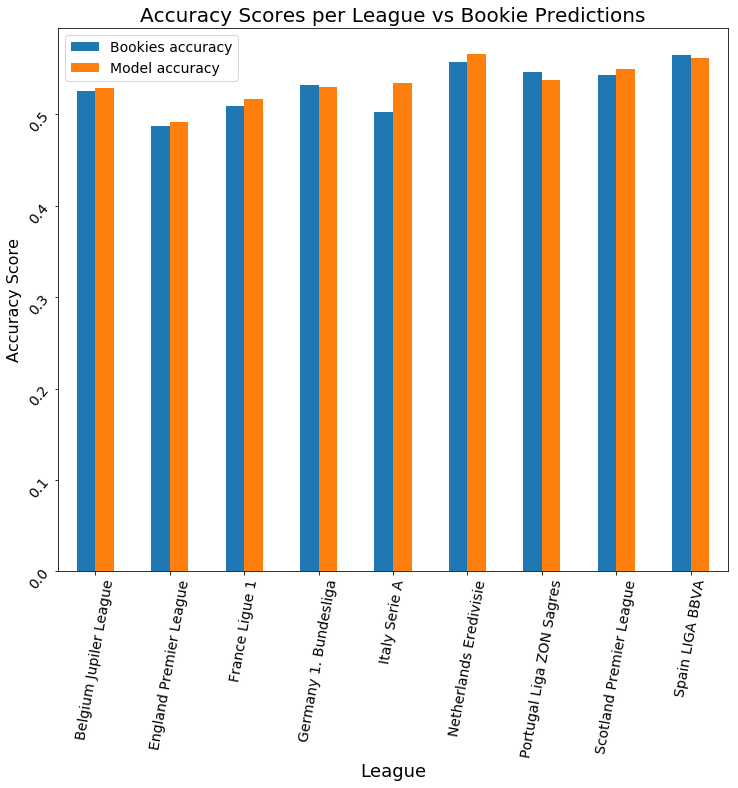

In [71]:
Match_Test_Leagues_accuracy_plot.plot(kind='bar')
plt.title("Accuracy Scores per League vs Bookie Predictions", fontsize=20)
plt.xlabel('League', fontsize=18)
plt.ylabel('Accuracy Score', fontsize=16)
plt.xticks(fontsize=14, rotation=80)
plt.yticks(fontsize=14, rotation=50)
plt.legend(loc=2, prop={'size': 14})
plt.show()

In [72]:
Basis_point_increase = (round(10000*(Match_Test_Leagues_plot1['Model_score'].sum()\
                             /Match_Test_Leagues_plot1['Total Matches'].sum()- \
                             Match_Test_Leagues_plot1['Bookies_score'].sum()\
                             /Match_Test_Leagues_plot1['Total Matches'].sum()),2))

print(f'Model accuracy is greater than bookies accuracy by {Basis_point_increase} basis points')

Model accuracy is greater than bookies accuracy by 60.33 basis points


## Using Model Predictions as a Betting Strategy:

<a id='Bet1'></a>
##### Betting Strategy 1: Place $10 the on predicted result by the model on every match in 2015

In [73]:
#Function to calculate payout for betting $10 based on the models predictions

def pay_out (df):
    
    Result = df['Result']
    Model_score = df['Model_score']
    
    #Payout for a $10 bet 
    home_win_payout = 10*(df['B365H'] - 1)
    draw_payout = 10*(df['B365D'] - 1)
    home_loss_payout = 10*(df['B365A']-1)
    
    if Model_score == 1:
        if Result == 1:
            payout = home_win_payout
        elif Result == 0:
            payout = draw_payout
        elif Result == -1:
            payout = home_loss_payout
    else: payout = -10
        
    return payout

In [74]:
Match_Test_Leagues['Bet_Return'] = Match_Test_Leagues.apply(lambda x: pay_out(x), axis = 1 )

Breaking down by league:

In [75]:
Engligh_Premier_League_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'England Premier League']
Scotland_Premier_League_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'Scotland Premier League']
Portugal_Liga_ZON_Sagres_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'Portugal Liga ZON Sagres']
Spain_LIGA_BBVA_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'Spain LIGA BBVA']
Italy_Serie_A_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'Italy Serie A']
France_Ligue_1_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'France Ligue 1']
Netherlands_Eredivisie_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'Netherlands Eredivisie']
Belgium_Jupiler_League_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'Belgium Jupiler League']
Germany_1_Bundesliga_df = Match_Test_Leagues[Match_Test_Leagues['League']== 'Germany 1. Bundesliga']

##### Profit Making Leagues in 2015:

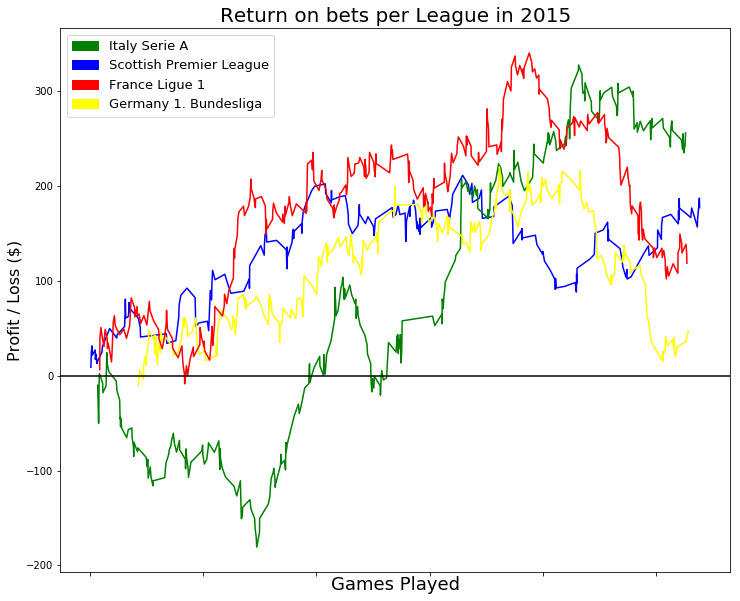

In [76]:
Scotland_Premier_League_df[Scotland_Premier_League_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-', color='blue');

Italy_Serie_A_df[Italy_Serie_A_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-', color='green');

Germany_1_Bundesliga_df[Germany_1_Bundesliga_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-', color='yellow');

France_Ligue_1_df[France_Ligue_1_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-', color='red');

blue_patch = mpatches.Patch(color='blue', label='Scottish Premier League')
green_patch = mpatches.Patch(color='green', label='Italy Serie A')
yellow_patch = mpatches.Patch(color='yellow', label='Germany 1. Bundesliga')
red_patch = mpatches.Patch(color='red', label='France Ligue 1')

plt.legend(handles=[green_patch,blue_patch,red_patch,yellow_patch],loc=2,prop={'size': 13})

plt.xlabel('Games Played', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

plt.title("Return on bets per League in 2015", fontsize=20)

axhline(0, color='black')

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;

##### Loss Making Leagues in 2015:

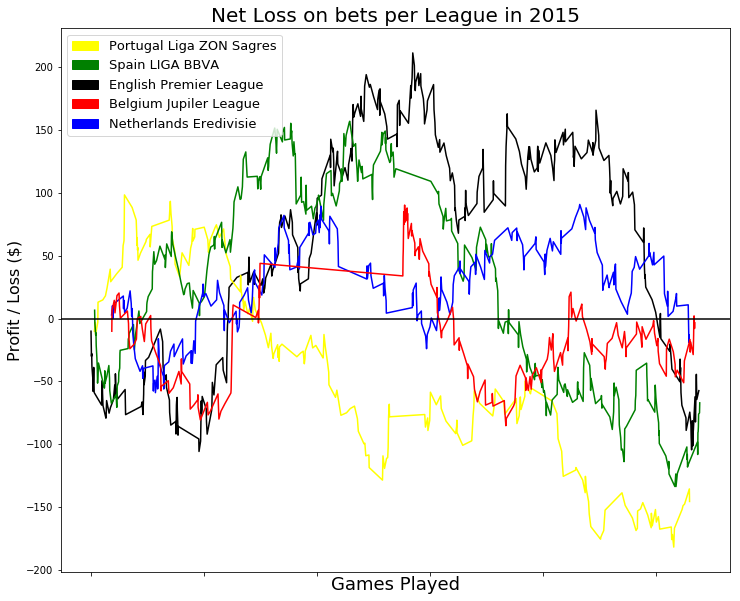

In [77]:
Engligh_Premier_League_df[Engligh_Premier_League_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-',color='black');

Portugal_Liga_ZON_Sagres_df[Portugal_Liga_ZON_Sagres_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-',color='yellow');

Spain_LIGA_BBVA_df[Spain_LIGA_BBVA_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-',color='green');

Netherlands_Eredivisie_df[Netherlands_Eredivisie_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-', color='blue');

Belgium_Jupiler_League_df[Belgium_Jupiler_League_df['date_year']==2015]\
['Bet_Return'].cumsum().plot(linestyle='-', color='red');

black_patch = mpatches.Patch(color='black', label='English Premier League')
yellow_patch = mpatches.Patch(color='yellow', label='Portugal Liga ZON Sagres')
green_patch = mpatches.Patch(color='green', label='Spain LIGA BBVA')
blue_patch = mpatches.Patch(color='blue', label='Netherlands Eredivisie')
red_patch = mpatches.Patch(color='red', label='Belgium Jupiler League')

plt.legend(handles=[yellow_patch,green_patch,black_patch,red_patch,blue_patch],loc=2,prop={'size': 13})

plt.xlabel('Games Played', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

axhline(0, color='black')

plt.title("Net Loss on bets per League in 2015", fontsize=20)

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;


Breakdown of Bet Return:

In [78]:
return_plot_df = Match_Test_Leagues.groupby(['League','date_year']).agg({'Bet_Return':sum}).sort_values(by=['League','date_year'],ascending=False)
return_plot_df.reset_index(inplace=True)
return_plot_df

,League,date_year,Bet_Return
0,Spain LIGA BBVA,2016,-37.8
1,Spain LIGA BBVA,2015,-67.0
2,Scotland Premier League,2016,16.9
3,Scotland Premier League,2015,177.5
4,Portugal Liga ZON Sagres,2016,-104.6
5,Portugal Liga ZON Sagres,2015,-145.5
6,Netherlands Eredivisie,2016,88.0
7,Netherlands Eredivisie,2015,-12.8
8,Italy Serie A,2016,-58.4
9,Italy Serie A,2015,256.2


<a id='Bet2'></a>
#### Betting Strategy 2:  Bet on games in which the models predicted probability of the predicted result  is greater than the bookies probability of the same result given the bookies odds for that result

In [79]:
#Pandas Series of logistic regression probabilities of each result

Match_Test_Leagues['Logistic_Probability_of_Home_Win'] = pipe_2.predict_proba(x_test)[:,2] #Home Win is indexed at 2 as its label is 1
Match_Test_Leagues['Logistic_Probability_of_Draw_Win'] = pipe_2.predict_proba(x_test)[:,1] #Draw is indexed at 1 as its label is 0
Match_Test_Leagues['Logistic_Probability_of_Home_Loss'] = pipe_2.predict_proba(x_test)[:,0] #Home Loss is indexed at 0 as its label is -1

In [80]:
def bookies_prob_home_win (df):
    
    ''' Returns bookies probability of a home win'''

    return (100 / df['B365H'])/100

def bookies_prob_draw (df):
    
    ''' Returns bookies probability of a draw'''

    return (100 / df['B365D'])/100

def bookies_prob_home_loss (df):
    
    ''' Returns bookies probability of a draw'''
    
    return (100 / df['B365A'])/100


In [81]:
#Adding bookies probabilities
Match_Test_Leagues['bookies_prob_home_win'] = Match_Test_Leagues.apply(lambda x: bookies_prob_home_win(x), axis =1)
Match_Test_Leagues['bookies_prob_draw'] = Match_Test_Leagues.apply(lambda x: bookies_prob_draw(x), axis =1)
Match_Test_Leagues['bookies_prob_home_loss'] = Match_Test_Leagues.apply(lambda x: bookies_prob_home_loss(x), axis =1)

In [82]:
def model_higher_than_bookies (df):
    
    '''Returns a 1 if model predicted probability greater than bookies predicted probability for that result'''
    
    Model_Prediction = df['Model_Prediction'] 
    
    if Model_Prediction == 1:
        if df['Logistic_Probability_of_Home_Win'] >= df['bookies_prob_home_win']:
            return 1
        else:
            return 0
    if Model_Prediction == 0:
        if df['Logistic_Probability_of_Draw_Win'] >= df['bookies_prob_draw']:
            return 1
        else:
            return 0
    if Model_Prediction == -1:
        if df['Logistic_Probability_of_Home_Loss'] >= df['bookies_prob_home_loss']:
            return 1
        else:
            return 0        

In [83]:
# Checking where model probabilities higher than bookies
Match_Test_Leagues['model_higher_than_bookies'] = Match_Test_Leagues.apply(lambda x: model_higher_than_bookies(x), axis =1)

In [84]:
Strategy1 = Match_Test_Leagues[Match_Test_Leagues['model_higher_than_bookies']==1]

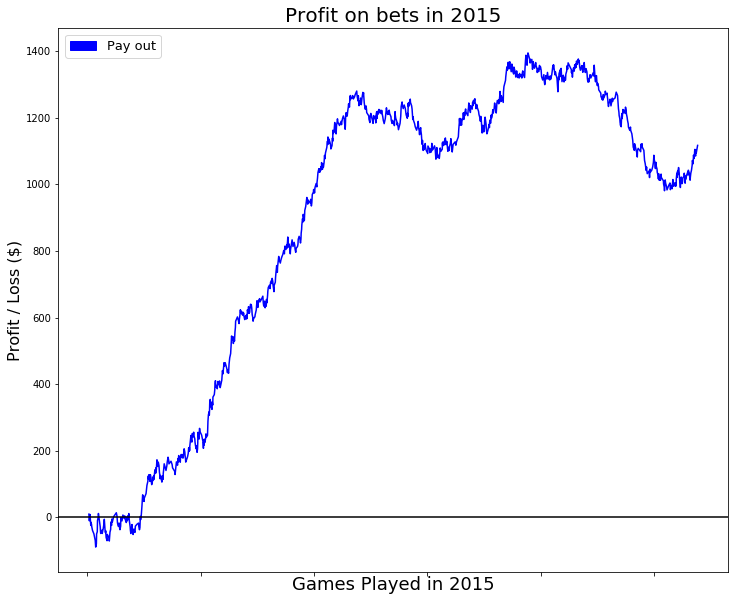

In [85]:
Strategy1[Strategy1['date_year']==2015]['Bet_Return'].cumsum().plot(linestyle='-',color='blue');

plt.xlabel('Games Played in 2015', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

blue_patch = mpatches.Patch(color='blue', label='Pay out')
plt.legend(handles=[blue_patch],loc=2,prop={'size': 13})

axhline(0, color='black')

plt.title("Profit on bets in 2015", fontsize=20)

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;

Breakdown by league:

In [86]:
Strategy1_Engligh_Premier_League_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'England Premier League']
Strategy1_Scotland_Premier_League_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'Scotland Premier League']
Strategy1_Portugal_Liga_ZON_Sagres_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'Portugal Liga ZON Sagres']
Strategy1_Spain_LIGA_BBVA_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'Spain LIGA BBVA']
Strategy1_Italy_Serie_A_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'Italy Serie A']
Strategy1_France_Ligue_1_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'France Ligue 1']
Strategy1_Netherlands_Eredivisie_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'Netherlands Eredivisie']
Strategy1_Belgium_Jupiler_League_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'Belgium Jupiler League']
Strategy1_Germany_1_Bundesliga_df = Strategy1[Strategy1['date_year']==2015][Strategy1['League']== 'Germany 1. Bundesliga']


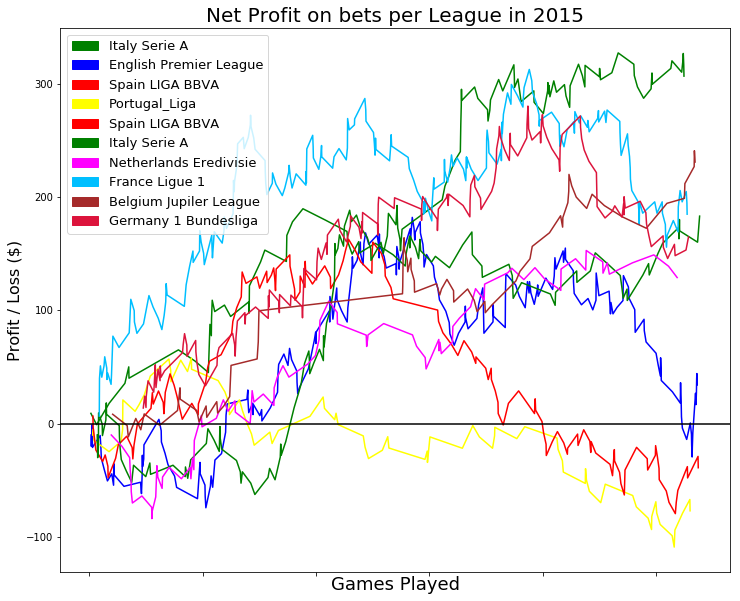

In [87]:
Strategy1_Engligh_Premier_League_df['Bet_Return'].cumsum().plot(linestyle='-', color='blue');
Strategy1_Scotland_Premier_League_df['Bet_Return'].cumsum().plot(linestyle='-', color='green');
Strategy1_Portugal_Liga_ZON_Sagres_df['Bet_Return'].cumsum().plot(linestyle='-', color='yellow');
Strategy1_Spain_LIGA_BBVA_df['Bet_Return'].cumsum().plot(linestyle='-', color='red');
Strategy1_Italy_Serie_A_df['Bet_Return'].cumsum().plot(linestyle='-', color='green');
Strategy1_France_Ligue_1_df['Bet_Return'].cumsum().plot(linestyle='-', color='deepskyblue');
Strategy1_Netherlands_Eredivisie_df['Bet_Return'].cumsum().plot(linestyle='-', color='magenta');
Strategy1_Belgium_Jupiler_League_df['Bet_Return'].cumsum().plot(linestyle='-', color='brown');
Strategy1_Germany_1_Bundesliga_df['Bet_Return'].cumsum().plot(linestyle='-', color='crimson');

blue_patch = mpatches.Patch(color='blue', label='English Premier League')
green_patch = mpatches.Patch(color='green', label='Scotish Premier League')
yellow_patch = mpatches.Patch(color='yellow', label='Portugal_Liga')
red_patch = mpatches.Patch(color='red', label='Spain LIGA BBVA')
green_patch = mpatches.Patch(color='green', label='Italy Serie A')
deepskyblue_patch = mpatches.Patch(color='deepskyblue', label='France Ligue 1')
magenta_patch = mpatches.Patch(color='magenta', label='Netherlands Eredivisie')
brown_patch = mpatches.Patch(color='brown', label='Belgium Jupiler League')
crimson_patch = mpatches.Patch(color='crimson', label='Germany 1 Bundesliga')


plt.legend(handles=[green_patch,blue_patch,red_patch,yellow_patch,red_patch,green_patch,magenta_patch,deepskyblue_patch,
                    brown_patch,crimson_patch
                   ],loc=2,prop={'size': 13})

plt.xlabel('Games Played', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

plt.title("Net Profit on bets per League in 2015", fontsize=20)

axhline(0, color='black')

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;

How many matches were bet on?

In [88]:
#Groupping by League for 2015 to analyze number of matches bet on vs total matches

Strategy1_breakdown = Match_Test_Leagues[Match_Test_Leagues['date_year']==2015].groupby(['League']).agg({'model_higher_than_bookies':sum,
                                         'Total Matches':sum})

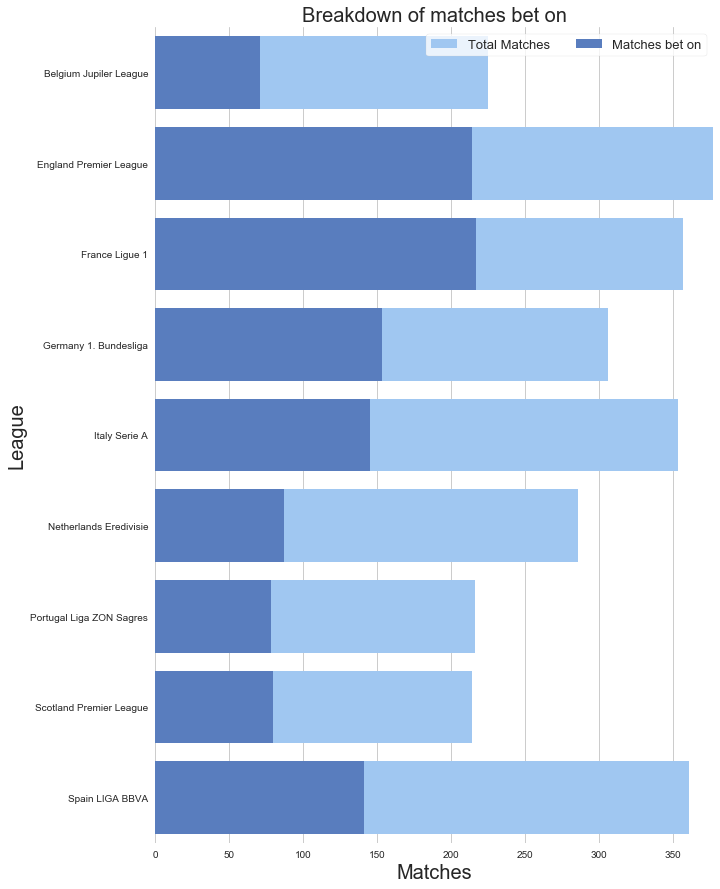

In [89]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x="Total Matches", y=Strategy1_breakdown.index, data=Strategy1_breakdown,
            label="Total Matches", color="b")

# Plot the matches where the model prediction probabilities for the correct result were higher than the bookies
sns.set_color_codes("muted")
sns.barplot(x="model_higher_than_bookies", y=Strategy1_breakdown.index, data=Strategy1_breakdown,
            label="Matches bet on", color="b")

# Add a legend and informative axis label
ax.legend(ncol=3, loc="top right", frameon=True,fontsize=13)
ax.set(xlim=(0, Strategy1_breakdown['Total Matches'].max())) 
ax.set_ylabel("League", fontsize=20)
ax.set_xlabel("Matches",fontsize=20)
sns.despine(left=True, bottom=True)

plt.title("Breakdown of matches bet on", fontsize=20)
plt.show;

### Return on Investment:

In [90]:
Net_Return = Strategy1[Strategy1['date_year']==2015].Bet_Return.sum()
Total_investments = len(Strategy1[Strategy1['date_year']==2015])*10
Return_on_investment = 100*round((Net_Return / Total_investments),4)
print(f'{Return_on_investment} ')

9.42 


##### 2015 Annual Return on Investment using Betting Strategy 2:   9.42%

<a id='Conclusion'></a>
## Conclusion

The model to predict the outcome of a soccer match is built using a combination of FIFA statistics and engineered features. The model with the highest accuracy score on the test match dataset was the Logistic Regression model. Using the models probability of the predicted result of a game and comparing it to the implied probability given the bookies odds for that result and only betting when the models probability is greater than the bookies. This strategy was tested across matches in 2015 and returned an annual 9.42% ROI.